In [1]:
import transformers.models.clip.image_processing_clip

In [2]:
%pip install langchain
%pip install qdrant-client
%pip install sentence_transformers
%pip install rank-bm25

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.docstore.document import Document
from langchain.vectorstores import Qdrant

import transformers.models.clip.image_processing_clip

from qdrant_client import QdrantClient 
from qdrant_client.models import Distance, VectorParams, PointStruct, HnswConfigDiff,OptimizersConfigDiff,ScalarQuantization,ScalarType, ScalarQuantizationConfig

import pandas as pd
from PIL import Image
import os
from tqdm import tqdm


In [3]:
metadata_f = pd.read_csv("C:/Users/thaka/Music/college/7. Sem 7/BTP/Model/men.csv", on_bad_lines='skip')

In [4]:
metadata_f.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,year,usage,productDisplayName,Unnamed: 9
0,24805,Men,Footwear,Shoes,Sports Shoes,Black,2007.0,Sports,Decathlon Men Black F300 Sports Shoes,NaN
1,37341,Boys,Apparel,Topwear,Tshirts,Orange,2008.0,Casual,U.S. Polo Assn. Kids Boys Orange T-shirt,NaN
2,39900,Men,Footwear,Shoes,Sports Shoes,White,2008.0,Sports,ADIDAS Men White Sukoi Sports Shoes,NaN
3,43341,Men,Footwear,Shoes,Sports Shoes,Grey,2008.0,Sports,Reebok Men Realflex Optimal Grey Sports Shoe,NaN
4,22542,Men,Footwear,Shoes,Sports Shoes,White,2009.0,Sports,Lotto Kids-Boy Jumper White Sports Shoes,NaN
5,2323,Men,Apparel,Topwear,Tshirts,White,2009.0,Casual,Reebok Men Club Stripe White Polo T-shirt,NaN
6,2327,Men,Apparel,Topwear,Tshirts,White,2009.0,Casual,Reebok Men Football Fanatic White T-shirt,NaN
7,17998,Men,Apparel,Topwear,Tshirts,Red,2009.0,Sports,Puma Men Graphic Tee Red Tshirt,NaN
8,47185,Men,Footwear,Shoes,Casual Shoes,Black,2010.0,Casual,Ganuchi Men Black Shoes,NaN
9,53633,Men,Footwear,Shoes,Casual Shoes,Olive,2010.0,Casual,ADIDAS Men Olive Shoes,NaN


In [5]:
SAMPLE_COUNT = 8000

In [6]:
BASE_PATH = "C:/Users/thaka/Music/college/7. Sem 7/BTP/Model/images"
count = 0
metdata_rows = []
sampled_image_paths = []
for index, row in metadata_f.iterrows():
    
    if count == SAMPLE_COUNT:
        break
        
    path = f"{BASE_PATH}/{row.id}.jpg"
    if not os.path.exists(path):
        continue
        
    sampled_image_paths.append(Image.open(path))
    metdata_rows.append(row)
    count = count+1
    
sampled_metadata_df = pd.DataFrame(metdata_rows, columns = metadata_f.columns)

In [7]:
sampled_metadata_df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,year,usage,productDisplayName,Unnamed: 9
0,24805,Men,Footwear,Shoes,Sports Shoes,Black,2007.0,Sports,Decathlon Men Black F300 Sports Shoes,NaN
1,37341,Boys,Apparel,Topwear,Tshirts,Orange,2008.0,Casual,U.S. Polo Assn. Kids Boys Orange T-shirt,NaN
2,39900,Men,Footwear,Shoes,Sports Shoes,White,2008.0,Sports,ADIDAS Men White Sukoi Sports Shoes,NaN
3,43341,Men,Footwear,Shoes,Sports Shoes,Grey,2008.0,Sports,Reebok Men Realflex Optimal Grey Sports Shoe,NaN
4,22542,Men,Footwear,Shoes,Sports Shoes,White,2009.0,Sports,Lotto Kids-Boy Jumper White Sports Shoes,NaN
5,2323,Men,Apparel,Topwear,Tshirts,White,2009.0,Casual,Reebok Men Club Stripe White Polo T-shirt,NaN
6,2327,Men,Apparel,Topwear,Tshirts,White,2009.0,Casual,Reebok Men Football Fanatic White T-shirt,NaN
7,17998,Men,Apparel,Topwear,Tshirts,Red,2009.0,Sports,Puma Men Graphic Tee Red Tshirt,NaN
8,47185,Men,Footwear,Shoes,Casual Shoes,Black,2010.0,Casual,Ganuchi Men Black Shoes,NaN
9,53633,Men,Footwear,Shoes,Casual Shoes,Olive,2010.0,Casual,ADIDAS Men Olive Shoes,NaN


In [8]:
sampled_metadata_df.drop(["id", "year"], axis=1, inplace=True)

In [9]:
def metadata_as_sentences():
    sentences = []
    
    for i, row in sampled_metadata_df.iterrows():
        sentences.append(" ".join([str(i) for i in row.values]))

    return sentences

In [10]:
metadata_as_sentence = metadata_as_sentences()

In [11]:
metadata_as_sentence[0:10]

['Men Footwear Shoes Sports Shoes Black Sports Decathlon Men Black F300 Sports Shoes nan',
 'Boys Apparel Topwear Tshirts Orange Casual U.S. Polo Assn. Kids Boys Orange T-shirt nan',
 'Men Footwear Shoes Sports Shoes White Sports ADIDAS Men White Sukoi Sports Shoes nan',
 'Men Footwear Shoes Sports Shoes Grey Sports Reebok Men Realflex Optimal Grey Sports Shoe nan',
 'Men Footwear Shoes Sports Shoes White Sports Lotto  Kids-Boy Jumper  White Sports Shoes nan',
 'Men Apparel Topwear Tshirts White Casual Reebok Men Club Stripe White Polo T-shirt nan',
 'Men Apparel Topwear Tshirts White Casual Reebok Men Football Fanatic White T-shirt nan',
 'Men Apparel Topwear Tshirts Red Sports Puma Men Graphic Tee Red Tshirt nan',
 'Men Footwear Shoes Casual Shoes Black Casual Ganuchi Men Black Shoes nan',
 'Men Footwear Shoes Casual Shoes Olive Casual ADIDAS Men Olive Shoes nan']

In [12]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load a CLIP model from huggingface
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)
model

SentenceTransformer(
  (0): CLIPModel()
)

In [13]:
sentence_as_documents = [Document(page_content=value, metadata={"image_id": _id}) for _id, value in enumerate(metadata_as_sentence)]
bm25_retriever = BM25Retriever.from_documents(sentence_as_documents)

In [14]:
image_dense_embeddings = []

for i in tqdm(sampled_image_paths):
    image_dense_embeddings.append(model.encode(i))

100%|██████████| 8000/8000 [21:31<00:00,  6.19it/s]


In [15]:
print(len(image_dense_embeddings), image_dense_embeddings[0].shape)


8000 (512,)


In [16]:
client = QdrantClient(path = ":memory:")

In [17]:
COLLECTION_NAME="semantic_image_search"

In [18]:
client.create_collection(COLLECTION_NAME, vectors_config=VectorParams(size=512,  distance=Distance.COSINE))

True

In [19]:
vector_line_batch = []
for i in tqdm(range(len(sampled_image_paths))):
    
    
    vector_line_batch.append(
        PointStruct(
                id=i,
                vector=image_dense_embeddings[i].tolist(),
                payload={"metadata":{"image_id": i}, "page_content":metadata_as_sentence[i]}
            )
    )
    
    if i % 100 == 0:
        
        client.upsert(
                collection_name=COLLECTION_NAME,
                wait=False,
                points=vector_line_batch
            )
        vector_line_batch = []

client.upsert(
        collection_name=COLLECTION_NAME,
        wait=False,
        points=vector_line_batch
    )

100%|██████████| 8000/8000 [00:10<00:00, 732.98it/s]


UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [20]:
from langchain.embeddings import SentenceTransformerEmbeddings
embeddings = SentenceTransformerEmbeddings(model_name='sentence-transformers/clip-ViT-B-32')

In [21]:
dense_vector_retriever = Qdrant(client, COLLECTION_NAME, embeddings)

In [22]:
bm25_retriever.k = 5

In [23]:
sparse_heavy_retiever = EnsembleRetriever(retrievers=[bm25_retriever, dense_vector_retriever.as_retriever()], weights=[0.8, 0.2])
dense_heavy_retiever = EnsembleRetriever(retrievers=[bm25_retriever, dense_vector_retriever.as_retriever()], weights=[0.2, 0.8])
neutral_retiever = EnsembleRetriever(retrievers=[bm25_retriever, dense_vector_retriever.as_retriever()], weights=[0.5, 0.5])

In [24]:
def search_and_show(retirever, query):
    search_result1 = retirever.get_relevant_documents(query)
    filtered_images, captions = get_results(search_result1)
    return display_result(filtered_images, captions)

In [25]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch, caption_batch):
    figures = []
    for i in range(len(caption_batch)):
        
        img = image_batch[i]
        caption = caption_batch[i]
        
        b = BytesIO()  
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
            
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" ></br>
              <span style="display:block; width:150px; word-wrap:break-word;"> {caption} </span>
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

In [26]:
def get_results(search_results):
    filtered_img_ids = [doc.metadata.get("image_id") for doc in search_results]
    filtered_images = [sampled_image_paths[_id] for _id in filtered_img_ids]

    captions = [doc.page_content for doc in search_results]
    return filtered_images, captions

In [27]:
# SEARCH_QUERY = "sun colour wear"
# search_and_show(neutral_retiever, SEARCH_QUERY) 

In [28]:
# nuuu="yellow"
# SEARCH_QUERY2 = nuuu+" clothes for women"

# search_result2 = dense_heavy_retiever.get_relevant_documents(SEARCH_QUERY2)
# filtered_images2, captions2 = get_results(search_result2)
# display_result(filtered_images2, captions2)
# # SEARCH_QUERY3 = "red clothes for men"

# # search_result3 = neutral_retiever.get_relevant_documents(SEARCH_QUERY3)
# # filtered_images3, captions3 = get_results(search_result3)
# # display_result(filtered_images3+filtered_images2, captions3+captions2)


In [29]:
extremelyfairskin = ["green", "Navy Blue","orange", "red", "blue"]
filtered_imagesX1=[]
captionsX1=[]
for i in extremelyfairskin:
    SEARCH_QUERY2 = i+" clothes for men"
    search_result2 = dense_heavy_retiever.get_relevant_documents(SEARCH_QUERY2)
    filtered_images2, captions2 = get_results(search_result2) 
    filtered_imagesX1+=filtered_images2
    captionsX1+=captions2


fairskin = [ "Navy Blue","green","yellow", "brown"]
filtered_imagesX2=[]
captionsX2=[]
for i in fairskin:
    SEARCH_QUERY2 = i+" clothes for men"
    search_result2 = dense_heavy_retiever.get_relevant_documents(SEARCH_QUERY2)
    filtered_images2, captions2 = get_results(search_result2) 
    filtered_imagesX2+=filtered_images2
    captionsX2+=captions2



oliveskin = [ "Navy Blue","maroon", "red","green", "purple","Burgundy"]
filtered_imagesX3=[]
captionsX3=[]
for i in oliveskin:
    SEARCH_QUERY2 = i+" clothes for men"
    search_result2 = dense_heavy_retiever.get_relevant_documents(SEARCH_QUERY2)
    filtered_images2, captions2 = get_results(search_result2) 
    filtered_imagesX3+=filtered_images2
    captionsX3+=captions2


LightBrownskin = ["Teal", "Navy Blue","blue", "burgundy", "grey"]
filtered_imagesX4=[]
captionsX4=[]
for i in LightBrownskin:
    SEARCH_QUERY2 = i+" clothes for men"
    search_result2 = dense_heavy_retiever.get_relevant_documents(SEARCH_QUERY2)
    filtered_images2, captions2 = get_results(search_result2) 
    filtered_imagesX4+=filtered_images2
    captionsX4+=captions2


Brownskin = ["green", "Navy Blue","blue", "yellow", "white"]
filtered_imagesX5=[]
captionsX5=[]
for i in Brownskin:
    SEARCH_QUERY2 = i+" clothes for men"
    search_result2 = dense_heavy_retiever.get_relevant_documents(SEARCH_QUERY2)
    filtered_images2, captions2 = get_results(search_result2) 
    filtered_imagesX5+=filtered_images2
    captionsX5+=captions2 


BlackBrownskin = ["Black", "Navy Blue","Pink", "burgundy", "White","grey"]
filtered_imagesX6=[]
captionsX6=[]
for i in BlackBrownskin:
    SEARCH_QUERY2 = i+" clothes for men"
    search_result2 = dense_heavy_retiever.get_relevant_documents(SEARCH_QUERY2)
    filtered_images2, captions2 = get_results(search_result2) 
    filtered_imagesX6+=filtered_images2
    captionsX6+=captions2  


Blackskin = ["Navy Blue", "Maroon","Pink", "Yellow", "White","grey","Orange","Blue"]
filtered_imagesX7=[]
captionsX7=[]
for i in BlackBrownskin:
    SEARCH_QUERY2 = i+" clothes for men"
    search_result2 = dense_heavy_retiever.get_relevant_documents(SEARCH_QUERY2)
    filtered_images2, captions2 = get_results(search_result2) 
    filtered_imagesX7+=filtered_images2
    captionsX7+=captions2  



CommonFashion = ["teal", "Navy Blue","blue", "white", "black","grey"]
filtered_imagesX8=[]
captionsX8=[]
for i in Brownskin:
    SEARCH_QUERY2 = i+" clothes for men"
    search_result2 = dense_heavy_retiever.get_relevant_documents(SEARCH_QUERY2)
    filtered_images2, captions2 = get_results(search_result2) 
    filtered_imagesX8+=filtered_images2
    captionsX8+=captions2        




In [30]:
print("1-extremelyfairskin\n2-fairskin\n3-oliveskin\n4-LightBrownskin\n5-Brownskin\n6-BlackBrownskin\n7-BlackSkin\n8-CommonFashion")

1-extremelyfairskin
2-fairskin
3-oliveskin
4-LightBrownskin
5-Brownskin
6-BlackBrownskin
7-BlackSkin
8-CommonFashion


In [31]:
def Fashion_choice(choice):
    switch ={
        1:display_result(filtered_imagesX1, captionsX1)  ,
        2:display_result(filtered_imagesX2, captionsX2)  ,
        3:display_result(filtered_imagesX3, captionsX3)  ,
        4:display_result(filtered_imagesX4, captionsX4)  ,
        5:display_result(filtered_imagesX5, captionsX5)  ,
        6:display_result(filtered_imagesX6, captionsX6)  ,
        7:display_result(filtered_imagesX7, captionsX7)  ,
        8:display_result(filtered_imagesX8, captionsX8)  ,
    }
    return switch.get(choice,"Invalid Choice")

In [34]:
num = int(input("Enter Choices from 1 to 8"))


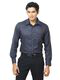
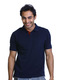
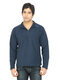
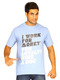
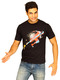
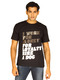
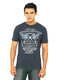
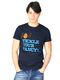
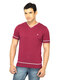
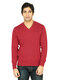
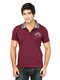
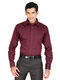
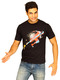
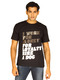
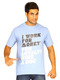
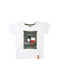
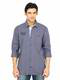
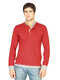
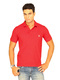
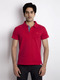
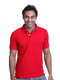
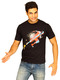
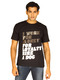
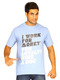
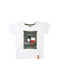
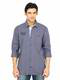
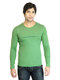
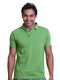
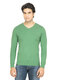
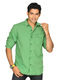
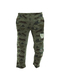
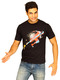
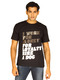
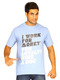
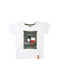
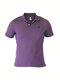
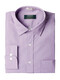
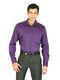
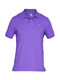
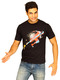
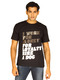
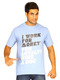
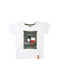
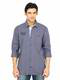
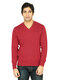
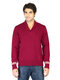
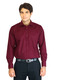
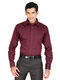
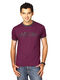
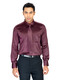
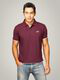

In [35]:
Fashion_choice(num)